In [58]:
# Re-importing necessary packages after the execution state reset
import pandas as pd
import numpy as np
import shap

import warnings
warnings.filterwarnings('ignore')

# Re-load the dataset
df_new = pd.read_csv('../data/transform/match_details_transformed.csv')

In [ ]:
cr = ['Unnamed: 0', 'match_api_id', 'season', 'stage', 'date', 'away_team', 'home_team','home_team_goal', 'away_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton', 'Unnamed: 0']
data_cleaned = df_new.drop(cr, axis=1)

data_cleaned.to_csv('../data/transform/df_new.csv')

data_cleaned.info()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data_cleaned.corr()

# Set the threshold for high correlation
high_corr_threshold = 0.9

# Find feature pairs with correlation greater than the threshold
# We are interested in absolute value of correlation coefficient
highly_correlated_pairs = correlation_matrix.abs().unstack().sort_values(kind="quicksort", ascending=False)
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= high_corr_threshold]
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs < 1]  # Remove self-correlation

# Since correlation is symmetric, we'll take one of each pair (the matrix is mirrored along the diagonal)
# We will only take the first of the pair to remove.
features_to_remove = set([pair[0] for pair in highly_correlated_pairs.index])

# Remove the features from the dataframe
data_reduced = data_cleaned.drop(columns=features_to_remove)

features_to_remove, data_reduced.shape

In [ ]:
def calculate_rolling_averages(rolling_window_size, df, stat_columns):
    """
    Calculate rolling averages for various statistics without including the current match.

    Args:
    - rolling_window_size (int): Number of previous matches to include in the rolling average.
    - df (pd.DataFrame): The DataFrame containing the match data.
    - stat_columns (dict): A dictionary with keys for each stat category (e.g., 'goals', 'possession', 'shots_on'),
                           and values being another dictionary with 'home' and 'away' keys mapping to the respective columns.

    Returns:
    - pd.DataFrame: The DataFrame with new rolling average columns added.
    """

    # Iterate through each stat category
    for stat, columns in stat_columns.items():
        # Define new feature names for rolling features
        home_feature_name = f'home_{stat}_rolling'
        away_feature_name = f'away_{stat}_rolling'

        # Calculate rolling averages for home and away statistics
        for team_type in ['home', 'away']:
            # Sort by team and date
            df.sort_values(by=[f'{team_type}_team', 'date'], ascending=True, inplace=True)
            
            # Calculate rolling averages for the given stat
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df.groupby(f'{team_type}_team')[columns[team_type]]
                .apply(lambda x: x.shift().rolling(window=rolling_window_size).mean())
                .reset_index(level=0, drop=True)
            )
            
            # Calculate the means for rolling features
            rolling_means = df.groupby(f'{team_type}_team')[home_feature_name if team_type == 'home' else away_feature_name].transform('mean')
            
            # Fill NaN values in rolling features with the team-specific means
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df[home_feature_name if team_type == 'home' else away_feature_name].fillna(rolling_means)
            )

    return df

# Usage example with goals, possession, and shots_on
stat_columns = {
    'goals': {
        'home': 'home_team_goal',
        'away': 'away_team_goal'
    },
    'possession': {
        'home': 'home_possession',
        'away': 'away_possession'
    },
    'shots_on': {
        'home': 'home_shoton',
        'away': 'away_shoton'
    }
}
# df_new = calculate_rolling_averages(6, df=df_new, stat_columns=stat_columns)

In [ ]:
cr = ['match_api_id', 'season', 'stage', 'date', 'away_team', 'home_team','home_team_goal', 'away_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton', 'Unnamed: 0']

In [ ]:
# df_new[['away_team', 'home_team']] = df_new[['away_team', 'home_team']].astype('int')

# df_new.info()

In [ ]:
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # or any other model you're using
from xgboost import XGBClassifier

# Define a range of window sizes to test
window_sizes = [3, 4, 5, 6, 7, 10, 12]

# Define your statistical categories and their corresponding columns
stat_columns = {
    'goals': {
        'home': 'home_team_goal',
        'away': 'away_team_goal'
    },
    'possession': {
        'home': 'home_possession',
        'away': 'away_possession'
    },
    'shots_on': {
        'home': 'home_shoton',
        'away': 'away_shoton'
    }
}

# Placeholder for best score and corresponding window size
best_score = -float('inf')
best_window_size = None

# Iterate over window sizes to find the best one
for window_size in window_sizes:
    # Calculate rolling averages using the current window size
    df_with_rolling = calculate_rolling_averages(window_size, df_new.copy(), stat_columns)

    df_with_rolling = df_with_rolling.drop(cr, axis=1)
    
    # Extract features and target for model training
    X = df_with_rolling.drop(['result_match'], axis=1)
    y = df_with_rolling['result_match']
    
    # Define your model
    model = XGBClassifier(random_state=42)  # Use your actual model here
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Change scoring method as needed
    
    # Calculate the mean score
    mean_score = scores.mean()
    
    # Update best score and window size if current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_window_size = window_size

# best_window_size now holds the size of the window that gave the best performance
print(f"Best window size: {best_window_size} with score: {best_score}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df_with_rolling = calculate_rolling_averages(6, df=df_new, stat_columns=stat_columns)
df_with_rolling = df_with_rolling.drop(cr, axis=1)

# Assume df_with_rolling is your DataFrame with rolling averages calculated
X = df_with_rolling.drop(['result_match'], axis=1)
y = df_with_rolling['result_match']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
model = XGBClassifier(random_state=42, objective="binary:logistic")

# Train the model
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Get feature importances
feature_importances = model.feature_importances_

# Sort the feature importances in descending order and print them
sorted_idx = feature_importances.argsort()[::-1]
for index in sorted_idx:
    print(f"{X_train.columns[index]}: {feature_importances[index]}")

In [ ]:
#Get shap values
explainer = shap.Explainer(model)
shap_values_cat= explainer(X_test)

print(np.shape(shap_values_cat))

In [ ]:
model.predict_proba(X_test)[0]

In [ ]:
# waterfall plot for class 0
shap.plots.waterfall(shap_values_cat[0,:,0])

# waterfall plot for class 1
shap.plots.waterfall(shap_values_cat[0,:,1])

# waterfall plot for class 2
shap.plots.waterfall(shap_values_cat[0,:,2])

In [ ]:
rolling_features=X_train.filter(like='rolling').columns

# Create the SHAP explainer object with the trained model
explainer = shap.Explainer(model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Since we have a multiclass classification, choose which class to visualize
# Let's say we choose class 1 (index 1) for this example
class_index = 1
shap_values_class = shap_values[:,:, class_index]

# Visualize the SHAP values with a summary plot for the chosen class
shap.summary_plot(shap_values_class, X_test)

# For an even deeper analysis, we can look at the SHAP values for each feature for each sample
# This is done using a beeswarm plot
shap.plots.beeswarm(shap_values_class, max_display=len(rolling_features))


# It can also be insightful to look at the interaction effects
# SHAP interaction values can decompose the SHAP values into main effects and interaction effects
# This can be computationally intensive and is recommended to be run on a subset of your data
shap_interaction_values = explainer.shap_interaction_values(X_test.iloc[:100])
shap.summary_plot(shap_interaction_values[class_index], X_test.iloc[:100], feature_names=rolling_features)

In [ ]:
import matplotlib.pyplot as plt

# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_cat.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values_cat.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values_cat.values[:,:,2]),axis=0)

df = pd.DataFrame({'away win':mean_0,'draw':mean_1,'home win':mean_2})

# plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP',size = 30)
ax.set_xticklabels(X.columns,rotation=45,size=20)
ax.legend(fontsize=30)

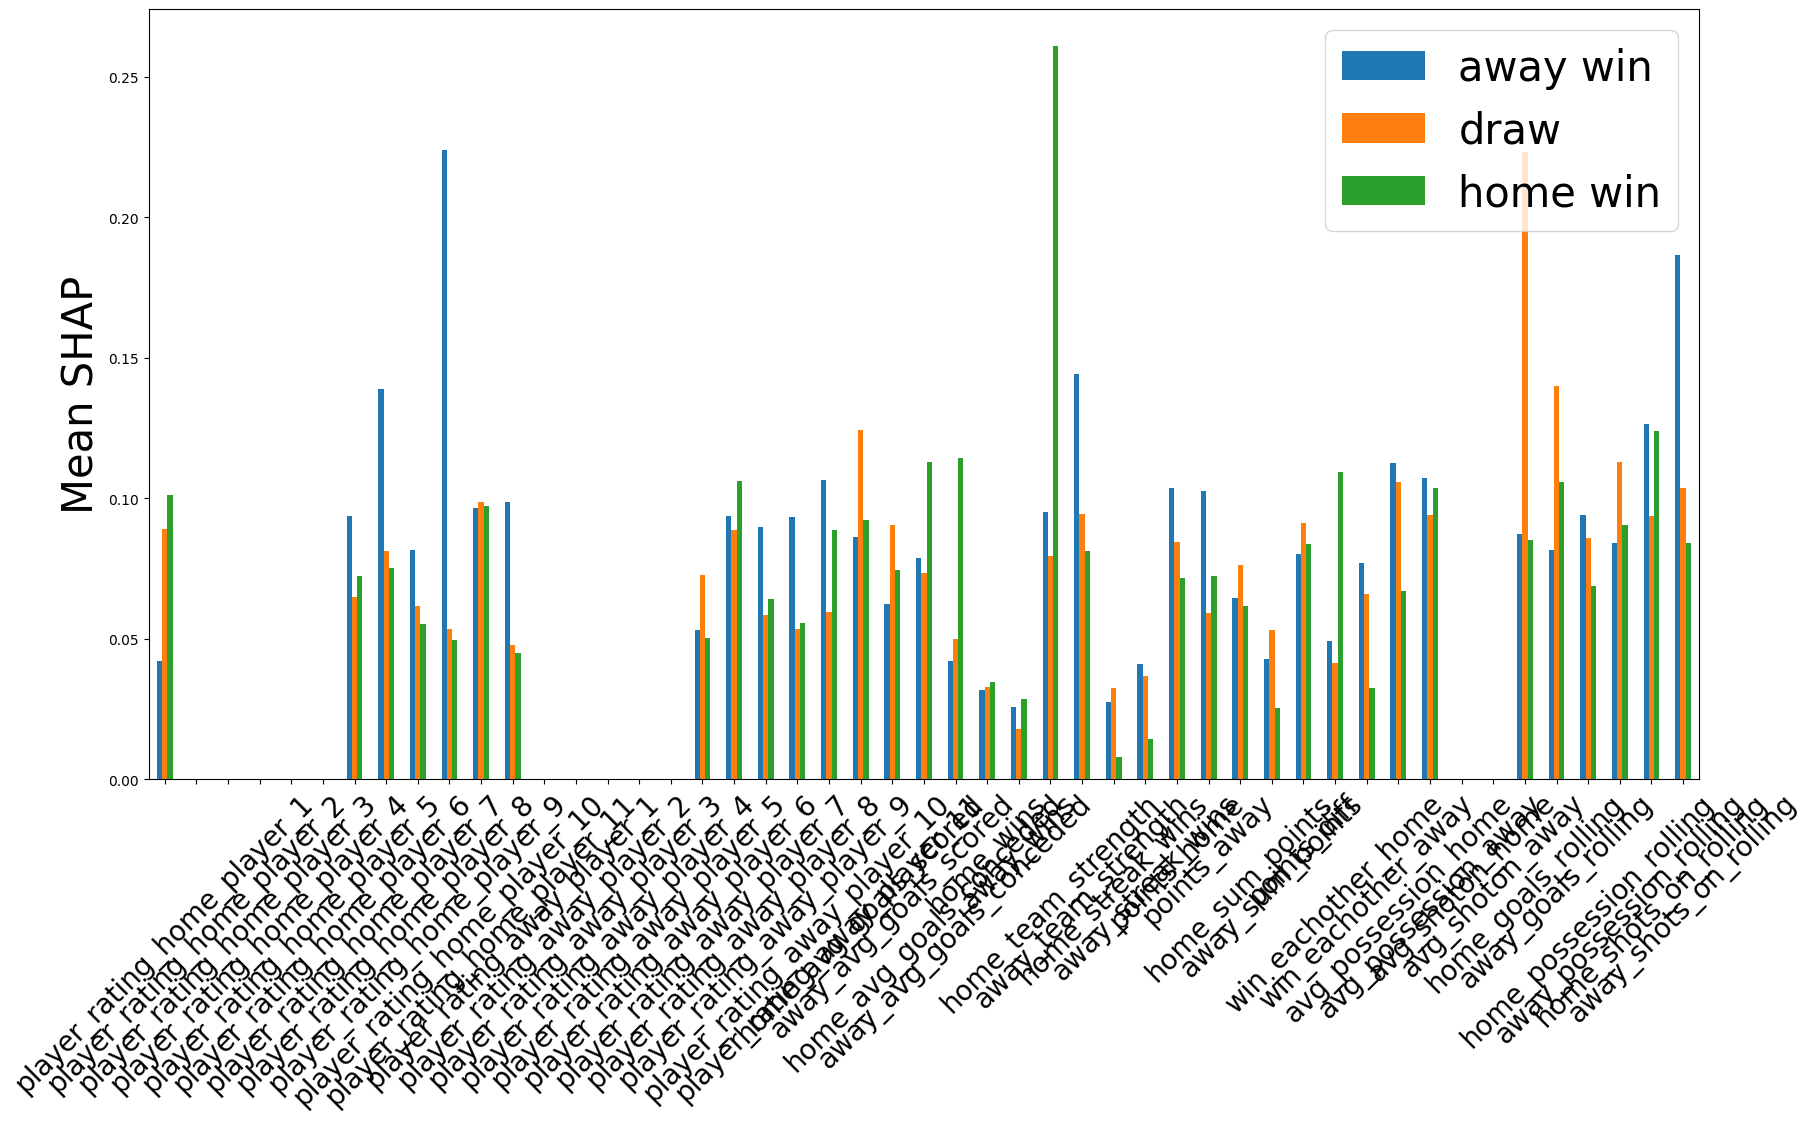

In [42]:
import matplotlib.pyplot as plt

# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_cat.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values_cat.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values_cat.values[:,:,2]),axis=0)

df = pd.DataFrame({'away win':mean_0,'draw':mean_1,'home win':mean_2})

# plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(20,10))
df.plot.bar(ax=ax)

ax.set_ylabel('Mean SHAP',size = 30)
ax.set_xticklabels(X.columns,rotation=45,size=20)
ax.legend(fontsize=30)